In [14]:
# %%
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from src.utils.load_dataframe import load_time_series_60min


In [15]:
# Check if GPU is available
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    # Activate GPU by default
    tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4612190722615462108
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 16586388216120220736
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]
Default GPU Device: /device:GPU:0


2024-09-12 16:05:27.554071: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:05:27.554088: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-09-12 16:05:27.554435: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:05:27.554461: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-09-12 16:05:27.554507: I tensor

In [16]:
# 1. Cargar los datos
df = load_time_series_60min()

In [17]:
# Seleccionar la columna de demanda de energía para Alemania
target_column = 'DE_load_actual_entsoe_transparency'
y = df[target_column].values


In [18]:
# Predecir usando solo la columna objetivo
X = y

In [19]:
# Asegurarse de que no haya valores nulos
X = X[~np.isnan(X)]
y = y[~np.isnan(y)]

In [20]:
# 2. Escalar los datos con MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X.reshape(-1, 1))

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [21]:
# Función para crear secuencias de tiempo
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [22]:
# Definir el tamaño de las secuencias de tiempo
seq_length = 60

In [23]:

# Crear secuencias a partir de X y y escalados
X_seq, y_seq = create_sequences(X_scaled, seq_length)
y_seq = y_seq.reshape(-1, 1)

In [24]:
# Redimensionar X para que sea compatible con la entrada de la CNN
X_seq = np.reshape(X_seq, (X_seq.shape[0], X_seq.shape[1], 1))

In [25]:
# 3. Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

In [26]:
# 4. Crear el modelo CNN con las mejoras
model = Sequential()

# Primera capa de convolución y max pooling
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

# Segunda capa de convolución y max pooling
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Añadir capa de aplanado y densas
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-09-12 16:05:28.324468: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-12 16:05:28.324484: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [27]:
# 5. Compilación del modelo usando Adam optimizer
optimizer = Adam(learning_rate=0.0005)  # Tasa de aprendizaje más baja
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [28]:
# Añadir early stopping para evitar overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [29]:
# 6. Entrenar el modelo
history = model.fit(
    X_train, y_train,
    epochs=100,  # Incrementar las épocas para mejorar la precisión
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

Epoch 1/100


2024-09-12 16:05:28.716829: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1259/1259 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0277 - val_loss: 0.0027
Epoch 2/100
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 3/100
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 4/100
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0030 - val_loss: 0.0014
Epoch 5/100
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 6/100
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 7/100
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 8/100
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 9/100
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 10/100
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 11/100
1259/1259 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0021 - val_loss: 9.5615e-04
Epoch 12/100
1259/1259

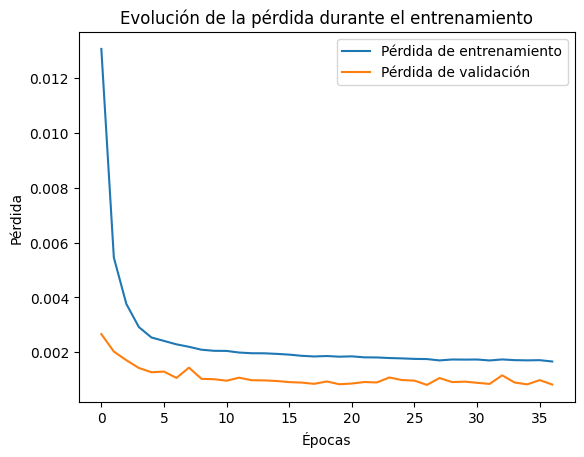

In [30]:
# 7. Graficar la evolución de la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

In [31]:
# 8. Hacer predicciones y revertir el escalado
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)
y_test = scaler_y.inverse_transform(y_test)

# 9. Evaluar el rendimiento del modelo
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Squared Error: 1715774.1990610925
Mean Absolute Error: 984.2320862665127


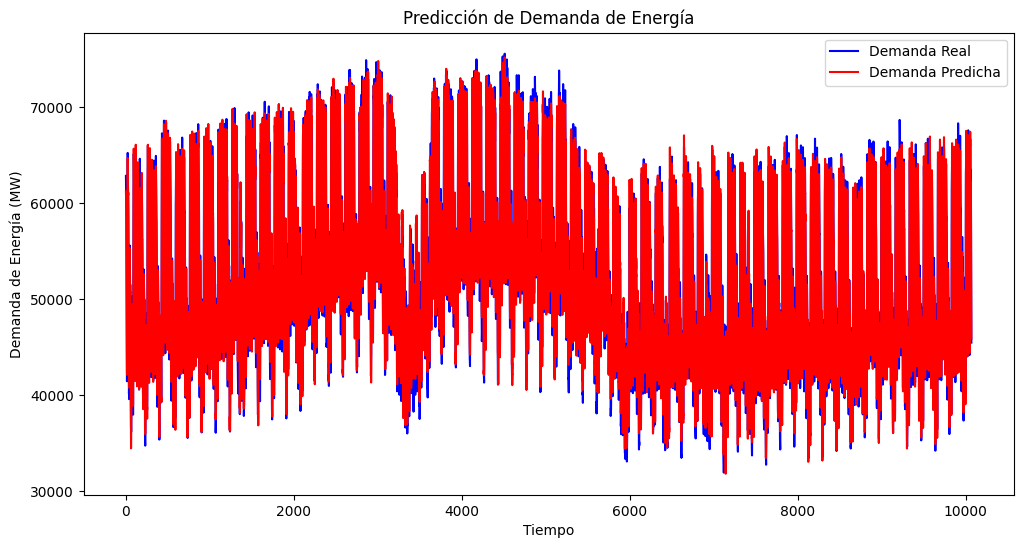

In [32]:
# 10. Graficar resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test, color='blue', label='Demanda Real')
plt.plot(y_pred, color='red', label='Demanda Predicha')
plt.title('Predicción de Demanda de Energía')
plt.xlabel('Tiempo')
plt.ylabel('Demanda de Energía (MW)')
plt.legend()
plt.show()

In [33]:
# 12. Mejorar predicciones mensuales para 2020
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])
df_2020 = df[df['utc_timestamp'].dt.year == 2020]
y_2020 = df_2020[target_column].values
y_2020_scaled = scaler_y.transform(y_2020.reshape(-1, 1))

# Crear secuencias y hacer predicciones para 2020
X_2020_seq, _ = create_sequences(y_2020_scaled, seq_length)
X_2020_seq = np.reshape(X_2020_seq, (X_2020_seq.shape[0], X_2020_seq.shape[1], 1))
predicciones_2020_scaled = model.predict(X_2020_seq)
predicciones_2020 = scaler_y.inverse_transform(predicciones_2020_scaled)

# Crear un DataFrame con predicciones y fechas
predicciones_2020_df = pd.DataFrame({
    'utc_timestamp': df_2020['utc_timestamp'][seq_length:],
    'predicciones': predicciones_2020.flatten()
})

# Agrupar por mes para predicciones mensuales
predicciones_mensuales_2020 = predicciones_2020_df.resample('M', on='utc_timestamp').sum()

204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


/var/folders/54/ddzf5nq5133324qrz2cb0_gc0000gn/T/ipykernel_86354/1841015930.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  predicciones_mensuales_2020 = predicciones_2020_df.resample('M', on='utc_timestamp').sum()


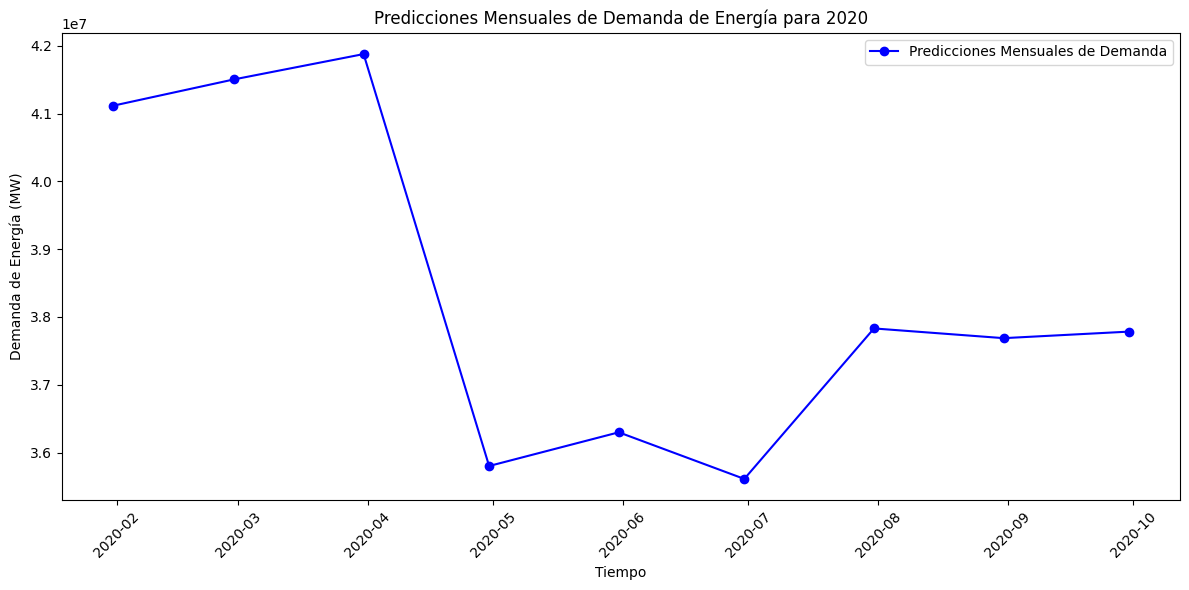

In [34]:
# Graficar predicciones mensuales
plt.figure(figsize=(12, 6))
plt.plot(predicciones_mensuales_2020.index, predicciones_mensuales_2020['predicciones'], color='blue', marker='o', label='Predicciones Mensuales de Demanda')
plt.title('Predicciones Mensuales de Demanda de Energía para 2020')
plt.xlabel('Tiempo')
plt.ylabel('Demanda de Energía (MW)')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()